In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Data reading

In [2]:
#raw_data = pd.read_csv("raw_data.csv")
raw_data = pd.read_csv("smooth_raw_data.csv")


In [3]:
raw_data.head(8)

,Sales,Item
0,-0.048506,IT001
1,0.019767,IT001
2,0.040116,IT001
3,-0.067794,IT001
4,0.147107,IT001
5,0.107668,IT001
6,0.053774,IT001
7,0.233600,IT001


### Train test split

Since the data is a sequence we cannot chose them randomly but to choose a cutoff of train data (80% first points).

In [4]:
n_points = 6#lookback 
# train test split
split = int(0.8 * len(raw_data))
train = raw_data["Sales"].values[:split+n_points] #little overlaping, extra n_points, index split show first column, we need n_points more
test = raw_data["Sales"].values[split:]

## Building dataset input to the deep learnig model 

*n_points* (N) is lookback number. it shows how many previous time  points in sequence is taken to the sample (row) in training/testing data. last column  is a label. 

In [5]:
def make_input(data,n_points):
    '''
    Function generating the np.array with train/test points as an input for ML models
    '''
    n_rows = len(data)
    result = np.empty((n_rows - n_points,n_points))
    for i in range(n_rows-n_points):
                result[i,:] = data[i : i+n_points]
    return result

In [6]:
data = raw_data["Sales"].values
X_train  = make_input(train,n_points)
X_test = make_input(test,n_points)
y_train = raw_data["Sales"].values[n_points:split+n_points]
y_test = raw_data["Sales"].values[split+n_points:]

In [7]:
#data visualisation
column_name = [f"T_(N-{i})" for i in range(n_points,0,-1)]
Xtrn = pd.DataFrame(X_train,columns = column_name)
Xtrn["label T_N"] = y_train
Xtrn

,T_(N-6),T_(N-5),T_(N-4),T_(N-3),T_(N-2),T_(N-1),label T_N
0,-0.048506,0.019767,0.040116,-0.067794,0.147107,0.107668,0.053774
1,0.019767,0.040116,-0.067794,0.147107,0.107668,0.053774,0.233600
2,0.040116,-0.067794,0.147107,0.107668,0.053774,0.233600,0.122611
3,-0.067794,0.147107,0.107668,0.053774,0.233600,0.122611,0.147552
4,0.147107,0.107668,0.053774,0.233600,0.122611,0.147552,0.076243
...,...,...,...,...,...,...,...
1195,-1.035467,-1.288729,-1.179826,-1.061486,-1.235705,-1.312734,-1.082842
1196,-1.288729,-1.179826,-1.061486,-1.235705,-1.312734,-1.082842,-1.006755
1197,-1.179826,-1.061486,-1.235705,-1.312734,-1.082842,-1.006755,-1.054599
1198,-1.061486,-1.235705,-1.312734,-1.082842,-1.006755,-1.054599,-1.135403


In [8]:
Xtst = pd.DataFrame(X_test,columns = column_name)
Xtst["label T_N"] = y_test
Xtst

,T_(N-6),T_(N-5),T_(N-4),T_(N-3),T_(N-2),T_(N-1),label T_N
0,-1.312734,-1.082842,-1.006755,-1.054599,-1.135403,-1.001528,-1.123523
1,-1.082842,-1.006755,-1.054599,-1.135403,-1.001528,-1.123523,-1.232927
2,-1.006755,-1.054599,-1.135403,-1.001528,-1.123523,-1.232927,-1.011258
3,-1.054599,-1.135403,-1.001528,-1.123523,-1.232927,-1.011258,-1.194356
4,-1.135403,-1.001528,-1.123523,-1.232927,-1.011258,-1.194356,-0.873230
...,...,...,...,...,...,...,...
289,-1.608900,-1.581273,-1.670592,-1.477001,-1.608354,-1.530242,-1.773212
290,-1.581273,-1.670592,-1.477001,-1.608354,-1.530242,-1.773212,-1.610350
291,-1.670592,-1.477001,-1.608354,-1.530242,-1.773212,-1.610350,-1.578478
292,-1.477001,-1.608354,-1.530242,-1.773212,-1.610350,-1.578478,-1.712295


### Scaling Data

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Building LSTM network

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,LSTM

In [12]:
model = Sequential()
#model.add(LSTM(4, input_shape=(1, n_points)))
model.add(LSTM(6,return_sequences=True))
model.add(LSTM(6,return_sequences=True))
model.add(LSTM(6))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape( (X_test.shape[0], 1, X_test.shape[1]))

In [14]:
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
1200/1200 - 2s - loss: 0.2445
Epoch 2/20
1200/1200 - 2s - loss: 0.0455
Epoch 3/20
1200/1200 - 2s - loss: 0.0361
Epoch 4/20
1200/1200 - 2s - loss: 0.0334
Epoch 5/20
1200/1200 - 2s - loss: 0.0300
Epoch 6/20
1200/1200 - 2s - loss: 0.0278
Epoch 7/20
1200/1200 - 2s - loss: 0.0261
Epoch 8/20
1200/1200 - 2s - loss: 0.0250
Epoch 9/20
1200/1200 - 2s - loss: 0.0237
Epoch 10/20
1200/1200 - 2s - loss: 0.0237
Epoch 11/20
1200/1200 - 2s - loss: 0.0240
Epoch 12/20
1200/1200 - 2s - loss: 0.0229
Epoch 13/20
1200/1200 - 2s - loss: 0.0230
Epoch 14/20
1200/1200 - 2s - loss: 0.0236
Epoch 15/20
1200/1200 - 2s - loss: 0.0228
Epoch 16/20
1200/1200 - 2s - loss: 0.0230
Epoch 17/20
1200/1200 - 2s - loss: 0.0223
Epoch 18/20
1200/1200 - 2s - loss: 0.0225
Epoch 19/20
1200/1200 - 2s - loss: 0.0228
Epoch 20/20
1200/1200 - 2s - loss: 0.0226


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 1, 6)                 312       
_________________________________________________________________
lstm_1 (LSTM)                (1, 1, 6)                 312       
_________________________________________________________________
lstm_2 (LSTM)                (1, 6)                    312       
_________________________________________________________________
dense (Dense)                (1, 1)                    7         
Total params: 943
Trainable params: 943
Non-trainable params: 0
_________________________________________________________________


In [16]:
#model.weights

Loss function plot

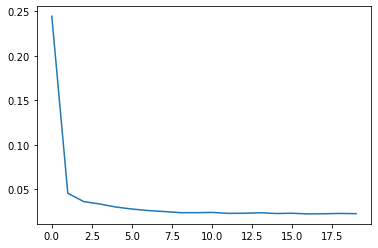

In [17]:
plt.plot(model.history.history["loss"])

## Model Evaluation

In [18]:
training_score = model.evaluate(X_train,y_train,verbose=0)
test_score = model.evaluate(X_test,y_test,verbose=0)

In [19]:
training_score

0.02279239147901535

In [20]:
test_score

0.029802091419696808

In [21]:
test_predictions = model.predict(X_test)

In [22]:
summary = pd.DataFrame({"test" : y_test.reshape(-1,),
                        "prediction":test_predictions.reshape(-1,)})

In [23]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
#TODO find other metrics

In [24]:
mean_absolute_error(summary['test'],summary['prediction'])

0.14112904894277575

In [25]:
mean_squared_error(summary['test'],summary['prediction'])

0.029802090596759076

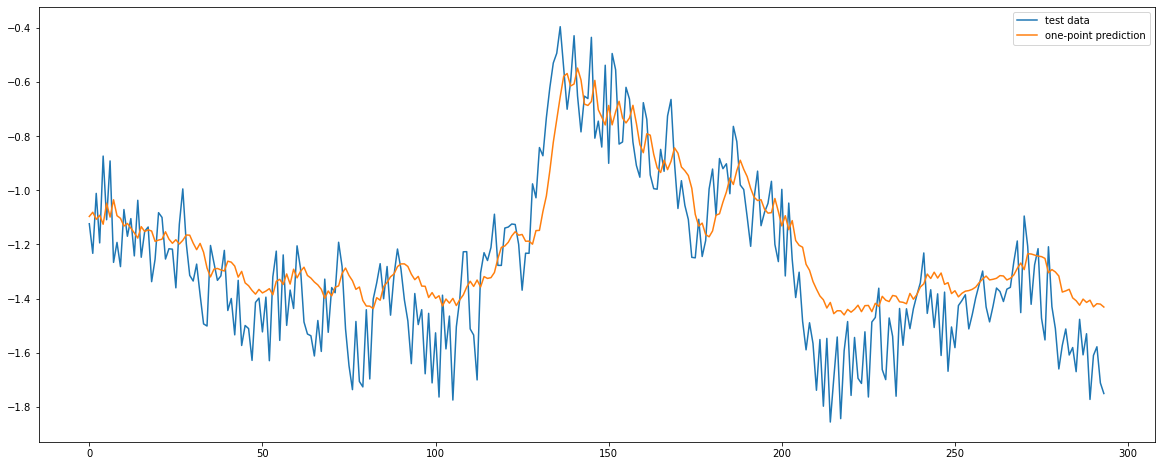

In [26]:
plt.figure(figsize=(20,8))
plt.plot(summary["test"])
plt.plot(summary["prediction"])
plt.legend(["test data", "one-point prediction"])

Comparison of test data, prediction and relative error

REMARK: I used only one point ahead prediction

In [27]:
summary['rel_error'] = np.abs((summary['test']- summary['prediction'])/summary['test'])

In [28]:
summary

,test,prediction,rel_error
0,-1.123523,-1.096479,0.024071
1,-1.232927,-1.080975,0.123246
2,-1.011258,-1.107090,0.094766
3,-1.194356,-1.092165,0.085562
4,-0.873230,-1.125351,0.288722
...,...,...,...
289,-1.773212,-1.406261,0.206941
290,-1.610350,-1.430847,0.111468
291,-1.578478,-1.419082,0.100980
292,-1.712295,-1.420792,0.170241


In [29]:
round(summary['rel_error'].mean(),2)

0.12

In [30]:
round(summary['rel_error'].std(),2)

0.1